<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/self_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langgraph langchain_groq langchain_huggingface langchain_community

In [2]:
!pip install langchain_community
!pip install duckduckgo-search
!pip install tiktoken
!pip install chromadb

  Using cached duckduckgo_search-7.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached primp-0.10.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached duckduckgo_search-7.2.1-py3-none-any.whl (19 kB)
Using cached primp-0.10.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.4 MB

In [3]:
from langchain_groq import ChatGroq
from google.colab import userdata
import os
os.environ['GROQ_API_KEY']=userdata.get('groq_api_key')
os.environ['HF_TOKEN']=userdata.get('HF_TOKEN')
llm = ChatGroq(model_name="Gemma2-9b-It")

In [4]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [55]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)

retriever = vectorstore.as_retriever()

In [56]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

#### Let's look into the retriever grader

In [57]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )



In [58]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [59]:
# Prompt
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..
If the document has words or meanings related to the question, mark it as relevant.
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [60]:
grade_prompt

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  \nIf the document has words or meanings related to the question, mark it as relevant.  \nGive a simple 'yes' or 'no' answer to show if the document is relevant or not."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])

In [61]:
my_retrieval_grader = grade_prompt | structured_llm_grader
question = "what is ai agent?"

In [62]:

docs = retriever.get_relevant_documents(question)

In [63]:
docs

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [64]:
doc_txt = docs[2].page_content

In [65]:
doc_txt

'Generative Agents Simulation#\nGenerative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.'

In [66]:
print(my_retrieval_grader.invoke({"document":doc_txt,"question": question}))

binary_score='yes'


In [67]:
question="who is sunny svaita?"

In [68]:
print(my_retrieval_grader.invoke({"document":doc_txt,"question": question}))

binary_score='no'


### let's look into the data generation

In [69]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

In [70]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [71]:
docs

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [72]:
rag_chain = prompt | llm

In [73]:
question="what is a AI agent?"

In [74]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question})

In [75]:
generation

AIMessage(content='An AI agent is a system with a large language model (LLM) as its core, capable of planning, remembering, and using tools to accomplish tasks.  These agents can break down complex problems into smaller steps and learn from their experiences to improve their performance. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 2066, 'total_tokens': 2123, 'completion_time': 0.103636364, 'prompt_time': 0.085860685, 'queue_time': 0.02441258099999999, 'total_time': 0.189497049}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-aa269025-cee6-4b70-b184-a259763e11ea-0', usage_metadata={'input_tokens': 2066, 'output_tokens': 57, 'total_tokens': 2123})

### Hallucination Grader

In [76]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )



In [77]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [78]:
# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [79]:
hallucinations_grader = hallucination_prompt | structured_llm_grader

In [80]:
print(hallucinations_grader.invoke({"documents": docs, "generation": generation}))

binary_score='yes'


#### Answer Grader

In [81]:
### Answer Grader
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question": question, "generation": generation}))

binary_score='yes'


### Question Re-writer

In [82]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.
You are given both a question and a document.
- First, check if the question is relevant to the document by identifying a connection or relevance between them.
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()


In [83]:
question="who is a current indian prime minister?"

In [84]:
question_rewriter.invoke({"question":question,"documents":docs})

'question not relevant \n'

In [85]:
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]

In [86]:
def retrieve(state:AgentState):
    print("----RETRIEVE----")
    question=state['question']
    documents=retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [87]:
def grade_documents(state:AgentState):
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']

    filtered_docs = []
    unfiltered_docs = []
    for doc in documents:
        score=my_retrieval_grader.invoke({"question":question, "document":doc})
        grade=score.binary_score

        if grade=='yes':
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(doc)
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs)>1:
        return {"unfilter_documents": unfiltered_docs,"filter_documents":[], "question": question}
    else:
        return {"filter_documents": filtered_docs,"unfilter_documents":[],"question": question}



In [88]:
def decide_to_generate(state:AgentState):
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]


    if unfiltered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query"
    if filtered_documents:
        print("----DECISION: GENERATE----")
        return "generate"

In [89]:
def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]

    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [90]:
from langgraph.graph import END, StateGraph, START
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]

    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"----RESPONSE---- {response}")
    if response == 'question not relevant':
        print("----QUESTION IS NOT AT ALL RELEVANT----")
        return {"documents":documents,"question":response,"generation":"question was not at all relevant"}
    else:
        return {"documents":documents,"question":response}

In [91]:
def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]

    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [92]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question= state['question']
    documents = state['documents']
    generation = state["generation"]

    score = hallucinations_grader.invoke({"documents":documents,"generation":generation})

    grade = score.binary_score

    #Check hallucinations
    if grade=='yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")

        print("---GRADE GENERATION vs QUESTION ---")

        score = answer_grader.invoke({"question":question,"generation":generation})

        grade = score.binary_score

        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"


### From here the Langgraph workflow will start

In [93]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents)
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)

In [94]:
workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
                            )
workflow.add_conditional_edges("Transform_User_Query",
                decide_to_generate_after_transformation,
                {
                "Retriever":"Docs_Vector_Retrieve",
                "query_not_at_all_relevant":END
                }
                )

In [95]:
app=workflow.compile()

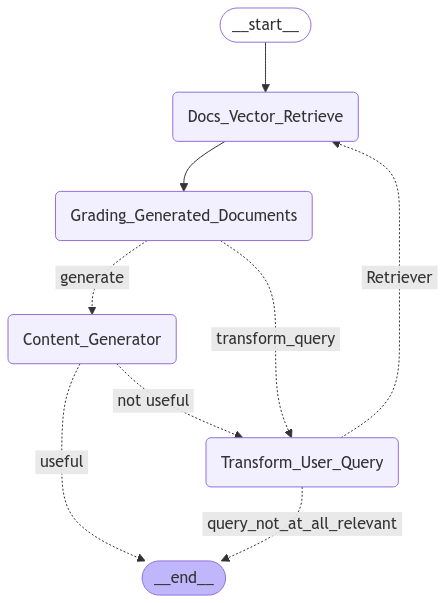

In [96]:
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [97]:
inputs = {"question": "Explain how the different types of agent memory work?"}

In [99]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content='This document describes two types of agent memory: short-term memory, which is used for in-context learning, and long-term memory, which stores information for extended periods often using an external vector store.  Long-term memory allows the agent to recall past information and use it to inform future actions. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 2080, 'total_tokens': 2146, 'completion_time': 0.12, 'prompt_time': 0.070844905, 'queue_time': 0.024502522, 'total_time': 0.190844905}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-a2ba82a7-0f7e-471c-9bb0-c8743305a46e-0', usage_metadata={'input_tokens': 2080, 'output_tokens': 66, 'total_tokens': 2146})

In [100]:
inputs = {"question": "who is a prompt engineering?"}

In [101]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION ADDRESS THE QUESTION ---


AIMessage(content="Prompt engineering is the art and science of designing effective prompts for large language models (LLMs) to elicit desired responses.  It involves carefully crafting input text to guide the LLM's behavior and generate specific, accurate, and relevant outputs.  Think of it like giving clear instructions to a very intelligent but literal-minded assistant. \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 1009, 'total_tokens': 1080, 'completion_time': 0.129090909, 'prompt_time': 0.032722132, 'queue_time': 0.024065117999999996, 'total_time': 0.161813041}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-f06f46f8-ae68-403d-a25d-ab8329b50c66-0', usage_metadata={'input_tokens': 1009, 'output_tokens': 71, 'total_tokens': 1080})

In [102]:
inputs = {"question": "what is role of data structure while creating ai agentic pattern?"}

In [105]:
inputs = {"question": "what is role of c language and php while creating ai agentic pattern?"}

In [106]:
app.invoke(inputs)

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----GRADE: DOCUMENT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----DECISION: GENERATE----
----GENERATE----
---CHECK HELLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION ---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY
this is my document[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by sev

{'question': 'how do agents utilize components like planning and memory when leveraging  LLMs? \n',
 'generation': AIMessage(content='Agents use planning to break down large tasks into smaller, manageable subgoals, enabling them to handle complex tasks efficiently.  They leverage memory, both short-term (in-context learning) and long-term (external vector stores), to retain and recall information, guiding their planning and decision-making.  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 1937, 'total_tokens': 2001, 'completion_time': 0.116363636, 'prompt_time': 0.080231297, 'queue_time': 0.022286523000000003, 'total_time': 0.196594933}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-819b0e9d-9c65-4d0b-b242-abf0c6b447c4-0', usage_metadata={'input_tokens': 1937, 'output_tokens': 64, 'total_tokens': 2001}),
 'documents': [Document(metadata={'description': 'Bui

In [107]:
inputs = {"question": "who is a first president of USA?"}

In [108]:
app.invoke(inputs)["generation"]

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS GRADED DOCUMENTS----
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
this is my document[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text gen

AIMessage(content='Short-term memory in language models is analogous to in-context learning, using the current prompt and previous interactions.  Long-term memory is achieved by storing information externally, often in a vector store, allowing the agent to recall past experiences and knowledge. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 2113, 'total_tokens': 2168, 'completion_time': 0.1, 'prompt_time': 0.068442211, 'queue_time': 0.026809375999999996, 'total_time': 0.168442211}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-9d504b23-9146-470e-981e-f339615d7ca5-0', usage_metadata={'input_tokens': 2113, 'output_tokens': 55, 'total_tokens': 2168})